In [0]:
import requests
from IPython.core.display import HTML
HTML(f"""
<style>
@import "https://cdn.jsdelivr.net/npm/bulma@0.9.4/css/bulma.min.css";
</style>
""")

# Using Scikit-Learn for regression with cross validation
This tutorial uses Scikit Learn's API for training and assessing models using cross validation. Please read the tutorial carefully before attempting to solve the exercise.
The tutorial covers the following topics:
- Create a scikit-learn pipeline for regression
- Training and evaluating the model using cross validation

As a first step, it is necessary to import the libraries:


In [0]:
import scipy.ndimage
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, KFold, RepeatedKFold

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
import numpy as np
import pandas as pd
import seaborn as sns

<article class="message is-info">
  <div class="message-header">Info</div>
  <div class="message-body">
  
  This tutorial uses the house pricing dataset included with the Scikit-Learn package. The built-in datasets are useful for experimenting and learning about different models and training methods. You can find a full list of available datasets on the [Scikit-Learn documentation page](https://scikit-learn.org/stable/modules/classes.html<elem-0>.datasets)


  
  </div>
</article>

Pandas dataframes are similar to numpy arrays but have named columns for easy identification. We use them only where this distinction makes the data significantly easier to work with. In the cell below the dataset is loaded and the full dataframe is extracted from it:


In [0]:
dataset = fetch_california_housing(as_frame=True)

df = dataset.frame # This is the dataframe (a table)
X = dataset.data # These are the input features (anything but the house price)
y = dataset.target # This contains the output features (just the house price)

print(df.describe()) # This method provides a convenient statistical summary of the columns
print('The dimensions of the dataset are:', df.shape) # Checking the shape of our dataset

Visualizing the data is important for understanding data and its structure.
The house pricing dataset consists of eight distinct features. The correlation matrix between these features is shown below: 


In [0]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# The Seaborn library makes complex plots like this trivial to implement.
sns.heatmap(dataset.frame.corr(), cmap=cmap)

The figure shows that median income, the average number of rooms, and the age of the houses are positively correlated with median housing prices. The strongest positive relationsip is observed between the median housing price and the median income. Latitude and longitude, which are geographic coordinates, display a negative correlation with each other. The average number of rooms has a strong positive correlated with the average number of bedrooms (obviously). The other variables show insignificant correlations with each other, or with the target variable.
## Model and training
Scikit Learn allows for defining model pipelines consisting of multiple steps containing multiple feature transformations and trainable models. The pipeline is considered as a single model when training and testing and can be used like a standalone model as long as the last element in the pipeline is a trainable model like a regression model (`LinearRegresssion`
) or a classifier(`LogisticRegresssion`
). The cell below defines a pipeline for a linear regression model with polynomial features and feature normalization:


In [0]:
model = Pipeline([
    ("features", PolynomialFeatures(2)), # Calculates the design matrix for a second order polynomial
    ("normalization", Normalizer()), # Normalizes the features to a (0, 1) range. 
    ("model", LinearRegression()), # The regression model
])

The cell below fits the linear regression model to the California Housing Prices dataset and calculates the R-squared ($R^2$) value of the model. $R^2$ is a value usually ranging between 0 and 1 that represents the proportion of the variance in the dependent variable (`MedHouseVal`
) that is explained by the independent variables (features) in the regression model. $R^2$ is a measure of the model's predictive power and is calculated as the ratio of the explained variance to the total variance:

$$
R^2 = \frac{{\sum_{i=1}^{n}(\hat{y}_i - \bar{y})^2}}{{\sum_{i=1}^{n}(y_i - \bar{y})^2}}
$$
The explained variance is the sum of the squared differences between the predicted labels ($\hat{y}$ = $f_w(x)$) and the mean of the training labels ($\bar{y}$). The total variance of the labes is the sum of the squared differences between the actual values of the labels and its mean. Overall the explained variance shows how much the predicted labels vary, while the total variance shows how much the original labels vary. $R^2$ is a commonly used metric to compare models to determine which model provides a better fit to the data (but it does not consider overfitting). 


In [0]:
# Fit the model to the dataset
model.fit(dataset.data, dataset.target) 
# Calculate the score on the training data
print('R-squared:',model.score(dataset.data, dataset.target))

## Hold-out validation
A simple validation method is **hold-out train-validation split**, where the training data is split into two sets containing a specific proportion of the overall data. The training set usually contains a larger proportion of the data ($70-90%$%), while the validation set contains the remaining elements. Scikit-learn provides a method [`train_test_split`
](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
 for implementing the hold-out method. In the cell below, we use this method to split the data, then we fit the model to the training split and evaluate the model on the validation data by obtaining the $R^2$ value:


In [0]:
X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=0.3, train_size=0.7)

model.fit(X_train, y_train)
print('R-squared:',model.score(X_test, y_test))

Based on the output above, the model shows a poorer fit then before. Remember that due to randomly splitting the dataset, and due to variability in model perfomance, you will get a different score every time you re-run the cell above. 
## Cross validation
<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">

<div class="has-text-centered">
<figure class="image is-inline-block" id="calibration">

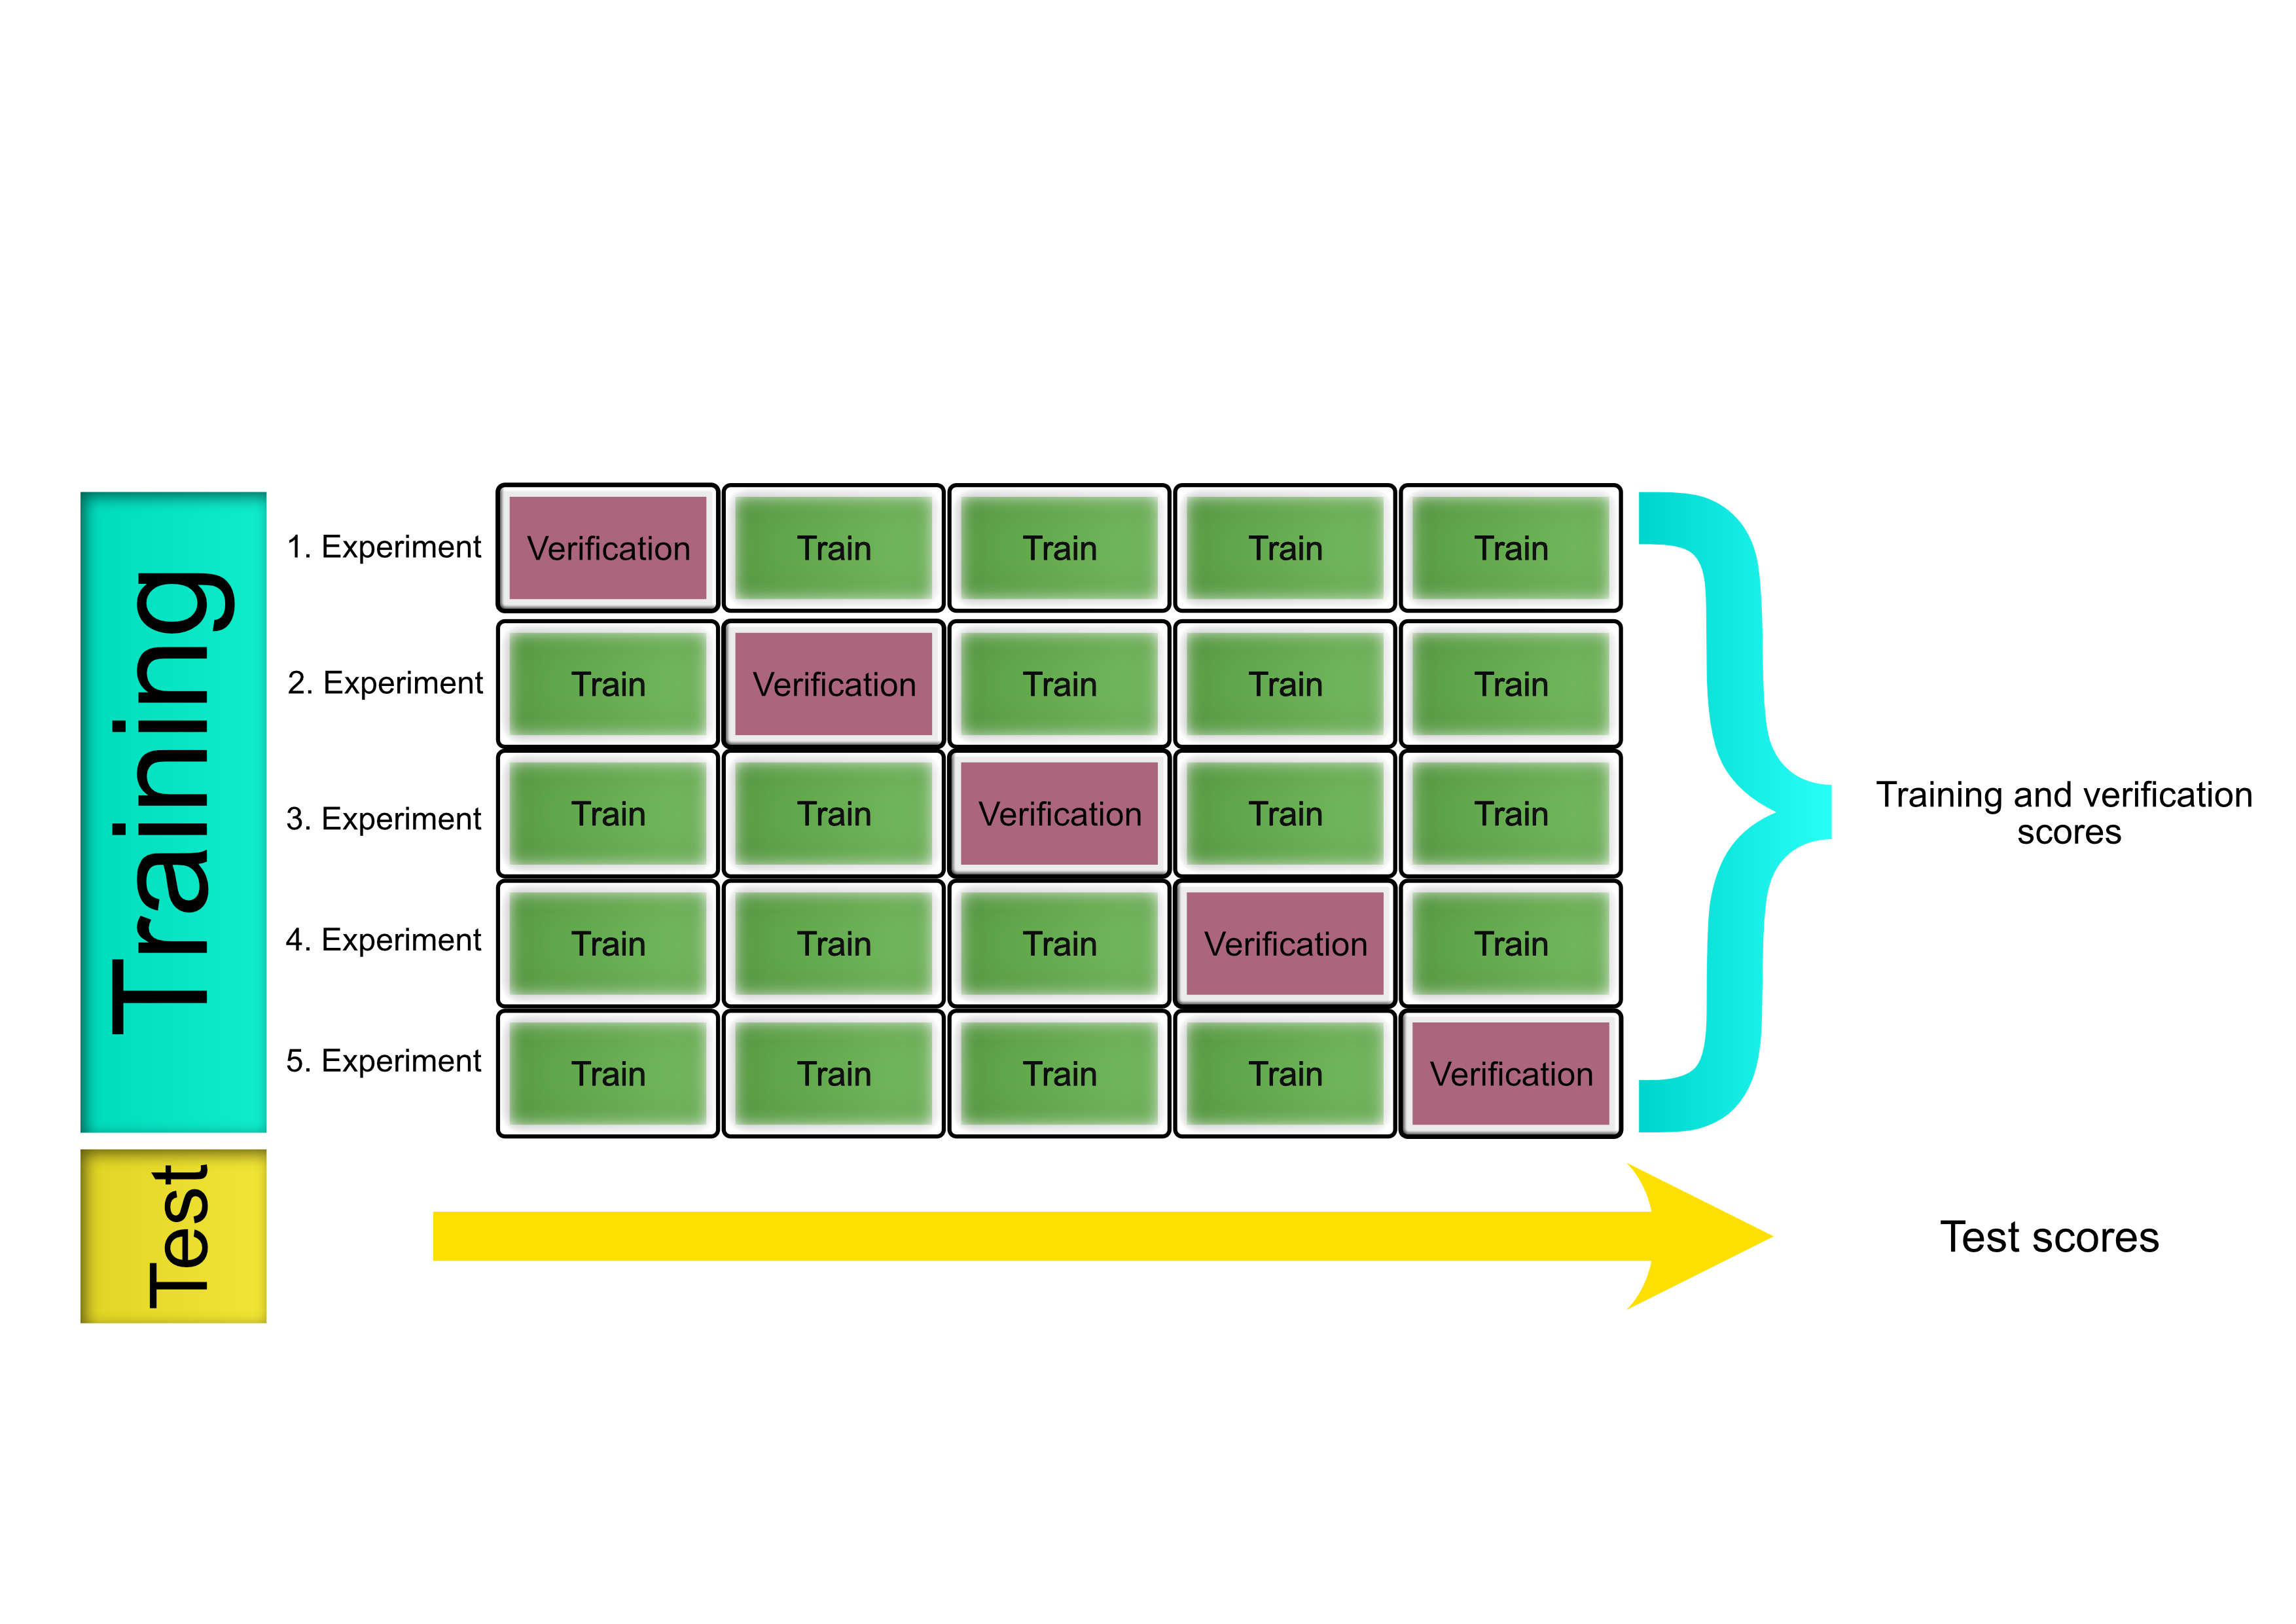

<figcaption class="figure-caption has-text-centered">Figure 1: K-fold cross validation with five folds</figcaption>
</figure>
</div>


</div>

Cross validation is a general technique used in machine learning to assess generalisation performance, by varying which subset of the training data is used for training and validation. There are multiple techniques for creating these subsets.
**K-fold cross validation** (shown in the figure above) works by splitting the dataset into $k$ folds, using $k-1$ parts for training and one for validating and not involving the test data at all. The model is trained $k$ times, such that each fold is used for validation once.
The function [`cross_validate`
](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html<elem-26>.model_selection.cross_validate)
 implements k-fold cross validation. We split the dataset into 100 equal folds with 99 folds used for training and one held out for validation (splitting into 100 folds is feasible as the dimensions of the dataset are 20640 x 9): 


In [0]:
kfold = KFold(100, shuffle=True)

results = cross_validate(
    model,
    dataset.data,
    dataset.target,
    cv=kfold,
    scoring="r2", 
    return_train_score=True,
    return_estimator=True,
)

validation_error = results["test_score"]
print('R-squared:',validation_error.mean())

The model shows a level of fit that closely resembles what we obtained in the previous setups. The model is showing consistent and reliable performance regardless of how the data is partitioned into folds. This can be a positive sign, indicating that the model has a good generalization ability and is likely to perform consistently on unseen data.
By modifying the number of folds we can change the portion of the dataset used for training, however the number of observations allocated to the testing set is also affected. The cell below investigates the influence of the number of folds ($k$) on model fit:


In [0]:
def k_fold_cv(k):
    kfold = KFold(n_splits=k, shuffle=True)

    return cross_validate(
        model,
        dataset.data,
        dataset.target,
        cv=kfold, # This parameter determines the number of folds
        scoring="r2", 
        return_train_score=True,
        return_estimator=True,
    )

r2_vals = []
r2_std = []
for i in [10, 50, 100, 150, 200]:
    res = k_fold_cv(i)
    r2_vals.append(res["test_score"].mean())
    r2_std.append(res["test_score"].std())


plt.figure(figsize=(10, 6))
plt.errorbar([10, 50,100, 150, 200], r2_vals, yerr=r2_std, fmt='o-', color='r', capsize=5)
plt.title('R2 Score vs. Number of Folds')
plt.xlabel('Number of Folds')
plt.ylabel('R2 Score (Mean)')
plt.xticks([10, 50,100, 150, 200])
plt.grid(True)
plt.show()

The plot above shows that mean $R^2$ values remain relatively stable, indicating that on average, the model performs well on unseen data, as 40% of the total variance of the labels is accounted for by the model. Regardless of the amount of training data or validation samples the model performs in a similar way, indicating that the model does not overfit to the data. On the other hand, there's a noticeable change in the error bars (standard deviation), showing that as the number of folds increase the variability in model perfomance increases as well. When the number of folds is increased, each fold represents a smaller portion of the data, and this can make the model fit more sensitive to the particular data subsets used in each fold. 
## Effects of polynomials on model fit
The cell below investigates the influence of the degree of the polynomial:


In [0]:
# Define the polynomial degrees
degrees = [3, 4, 5]

# Initialize lists to store the model scores for training and testing
train_scores = []
test_scores = []

# Loop through each polynomial degree and fit the model
for degree in degrees:
    model = Pipeline([
        ("features", PolynomialFeatures(degree)),
        ("normalization", Normalizer()),
        ("model", LinearRegression(fit_intercept=True))
    ])
    
    model.fit(X_train, y_train)
    
    # Calculate the R-squared score for training data
    train_score = model.score(X_train, y_train)
    train_scores.append(train_score)
    
    # Calculate the R-squared score for testing data
    test_score = model.score(X_test, y_test)
    test_scores.append(test_score)

    # Calculate standard deviations of training and testing scores
    train_std = np.std(train_scores)
    test_std = np.std(test_scores)

# Create a line plot
plt.figure(figsize=(8, 6))
plt.errorbar(degrees, train_scores, yerr=train_std, label='Training Score', marker='o', linestyle='-', color='b')
plt.title('Model Scores with Standard Deviation')
plt.xlabel('Polynomial Degree')
plt.ylabel('R-squared Score')
plt.legend()
plt.grid(True)
plt.xticks(degrees)
plt.ylim(0.35, 0.9)  # Adjust the y-axis limits if needed
plt.show()

As illustrated in the plot, increasing the degree of the polynomial results in the model fitting the training data increasingly better and the variance remains about the same. The cell below examines the model's performance on the validation set which can give us a deeper insight into the predictive power of the model:


In [0]:
print(test_scores)

The R-squared values are negative, indicating that regression model is exceptionally poor. In fact a negative R-squared value implies that our predictions would be more accurate by simply forecasting the mean of the label variable, rather than using the regression model. The reason is that with a polynomial degree higher than 2, the model is overfitting the data and becomes overly sensitive to noise within the data rather than capturing the underlying trend.
